# ROC and precision-recall curves

Nuha BinTayyash, 2020

This notebook shows the ROC and precision-recall curves resulted from running GPcounts with one sample test on simulated bulk RNA-seq datasets.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import stats

In [2]:
from scipy import interpolate

def qvalue(pv, pi0=None):
    
    '''
    Estimates q-values from p-values
    This function is modified based on https://github.com/nfusi/qvalue

    GitHub - nfusi/qvalue: Converts p-values in q-values, see (Storey and Tibshirani, 2003)
    qvalue. Converts p-values in q-values, see (Storey and Tibshirani, 2003) The only function that needs to be called is 'estimate()'. It will accept a numpy array of pvalues and will return a numpy array of qvalues.
    github.com

    Args
    ====
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
    '''

    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    m = float(len(pv))

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = np.arange(0, 0.90, 0.01)
        counts = np.array([(pv > i).sum() for i in np.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = np.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)

        if pi0 > 1:
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    p_ordered = np.argsort(pv)
    pv = pv[p_ordered]
    qv = pi0 * m/len(pv) * pv
    qv[-1] = min(qv[-1], 1.0)

    for i in range(len(pv)-2, -1, -1):
        qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

    # reorder qvalues
    qv_temp = qv.copy()
    qv = np.zeros_like(qv)
    qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv


### Exons 

In [3]:
NegativeBinomial = pd.read_csv('ll_Negative_binomial_exons_counts.csv',index_col=[0])
NegativeBinomial['log_likelihood_ratio'] = pd.to_numeric(NegativeBinomial['log_likelihood_ratio'], errors='coerce')
nan_gene = list(NegativeBinomial[NegativeBinomial['log_likelihood_ratio'].isnull()].index.values)
NegativeBinomial = NegativeBinomial.drop(nan_gene)
NegativeBinomial

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,time,failure counter
FBgn0000003,-73.7899363362756,-68.52892952423885,-5.261007,0:00:09.277584,0
FBgn0000008,-115.45385720660255,-147.467852809965,32.013996,0:00:05.823610,0
FBgn0000014,-49.159336901470965,-79.54083562055467,30.381499,0:00:06.675063,0
FBgn0000015,-26.47604613053277,-38.467021705493,11.990976,0:00:05.362831,0
FBgn0000017,-165.56235815619738,-201.7558911894686,36.193533,0:00:06.847503,0
...,...,...,...,...,...
FBgn0285954,-94.9151034656098,-108.68849549863636,13.773392,0:00:04.923832,1
FBgn0285955,-32.422456924308484,-46.31973778917264,13.897281,0:00:02.990246,0
FBgn0285962,-94.03234694846505,-89.88310397447434,-4.149243,0:00:05.222474,1
FBgn0285971,-131.3216404477003,-473.31464760876383,341.993007,0:00:02.596877,0


In [4]:
Gaussian = pd.read_csv('ll_Gaussian_exons_counts.csv',index_col=[0])
Gaussian['log_likelihood_ratio'] = pd.to_numeric(Gaussian['log_likelihood_ratio'], errors='coerce')
Gaussian = Gaussian.drop(nan_gene)
Gaussian 

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,time,failure counter
FBgn0000003,-12.043035,-11.454129,-0.588906,0:00:00.583296,0
FBgn0000008,-20.419973,-51.580668,31.160696,0:00:00.549918,0
FBgn0000014,-9.007350,-54.453686,45.446335,0:00:00.571156,0
FBgn0000015,-19.377525,-40.122539,20.745015,0:00:00.566677,0
FBgn0000017,-6.891059,-18.298687,11.407628,0:00:00.580477,0
...,...,...,...,...,...
FBgn0285954,-3.320550,-13.022536,9.701986,0:00:00.890007,0
FBgn0285955,-15.405277,-43.393667,27.988391,0:00:00.568858,0
FBgn0285962,16.249576,16.277114,-0.027538,0:00:00.564914,0
FBgn0285971,3.360024,-32.029308,35.389332,0:00:00.590313,0


8207


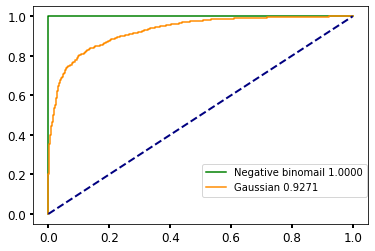

Number of differentially expressed genes:        Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
label                                                                
0.0                             953                            953   
1.0                            7254                           7254   

       log_likelihood_ratio  time  failure counter  
label                                               
0.0                     953   953              953  
1.0                    7254  7254             7254  
AUC for GPcounts with Negative Binomial likelihood 1.0
AUC for GPcounts with Gaussian likelihood 0.9271084217095116
GPcounts with Negative Binomial likelihood
AUC: 1.0
the numbers of genes less than 0.05 : 6377
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


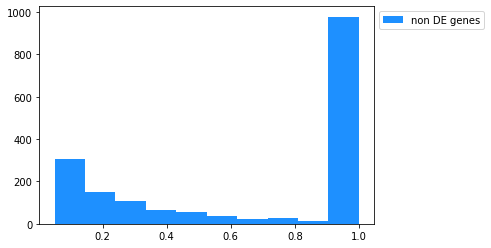

1762


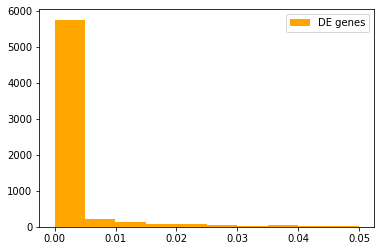

GPcounts with Gaussian likelihood
AUC: 0.9271084217095116
the numbers of genes greater than 0.05 : 7317
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


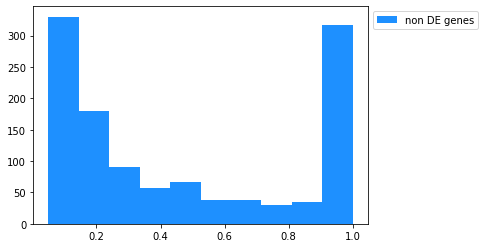

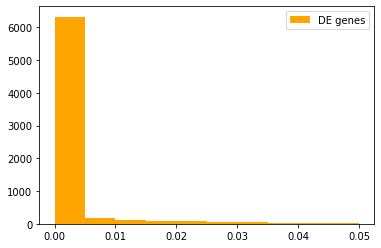

In [5]:

D = NegativeBinomial.shape[0]
print(D)

true_label = np.zeros(D)
for j in range(D):
    if NegativeBinomial['log_likelihood_ratio'][j] > 0:
        true_label[j] = 1
   
labels = pd.DataFrame(true_label, index =NegativeBinomial.index.values, columns =['label'])
NegativeBinomial = pd.concat([NegativeBinomial,labels],axis = 1)

fig = plt.figure()

plt.tick_params(labelsize='large', width=2)     
fpr_NB, tpr_NB, thresholds_NB = metrics.roc_curve( NegativeBinomial['label'], NegativeBinomial['log_likelihood_ratio'])
AUC_NB=metrics.auc(fpr_NB, tpr_NB)
plt.plot(fpr_NB, tpr_NB,color='green',label='Negative binomail {0:.4f}'.format(AUC_NB))


fpr_G, tpr_G, thresholds_G = metrics.roc_curve(NegativeBinomial['label'],Gaussian['log_likelihood_ratio'])
AUC_G=metrics.auc(fpr_G, tpr_G)
plt.plot(fpr_G, tpr_G, color='darkorange', label='Gaussian {0:.4f}'.format(AUC_G))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
'''
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1, 2, 2)

precision_NB, recall_NB, thresholds_NB = metrics.precision_recall_curve( NegativeBinomial['label'], NegativeBinomial['log_likelihood_ratio'])
plt.plot( recall_NB,precision_NB,color='green',label='GPcounts with Negative binomail likelihood')

precision_G, recall_G, thresholds_G = metrics.precision_recall_curve(NegativeBinomial['label'],Gaussian['log_likelihood_ratio'])
plt.plot(recall_G, precision_G, color='darkorange', label='GPcounts with Gaussian ll')

precision_P, recall_P, thresholds_P = metrics.precision_recall_curve( NegativeBinomial['label'], Poisson['log_likelihood_ratio'])
plt.plot( recall_P,precision_P,color='blue',label='GPcounts with Poisson ll')

plt.xlabel('recall')
plt.ylabel('precision')
'''
plt.legend(loc='upper center', bbox_to_anchor=(.75, 0.30))
plt.show()

print('Number of differentially expressed genes:',NegativeBinomial.groupby('label').count())
print('AUC for GPcounts with Negative Binomial likelihood',AUC_NB)
print('AUC for GPcounts with Gaussian likelihood',AUC_G)


pval_NB = 1 - stats.chi2.cdf(NegativeBinomial['log_likelihood_ratio'], df=1)
pval_NB.reshape(-1)[2]
pval_NB = pd.DataFrame(pval_NB)
DE_pval_NB = list(pval_NB.loc[(pval_NB[0] < 0.05)].index.values)
non_DE_pval_NB = list(pval_NB.loc[(pval_NB[0] >= 0.05)].index.values)

qvals_NB = []
#pval_NB=pval_NB['2']
qvals_NB = qvalue(pval_NB.values)
count_NB = 0

for i in (qvals_NB):
    if i < 0.05 :
        count_NB = count_NB + 1
    
print("GPcounts with Negative Binomial likelihood")        
print('AUC:',AUC_NB)       
print ("the numbers of genes less than 0.05 : " + str(count_NB))
print("kstest for non DE genes:",stats.kstest(pval_NB.iloc[non_DE_pval_NB,:].values, 'uniform', args=(0,1)))
plt.hist(pval_NB.iloc[non_DE_pval_NB,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
print(len(pval_NB.iloc[non_DE_pval_NB,:].values.ravel()))
plt.hist(pval_NB.iloc[DE_pval_NB,:].values.ravel(),color="orange", label="DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

pval_G = 1 - stats.chi2.cdf(Gaussian['log_likelihood_ratio'], df=1)
pval_G.reshape(-1)[2]
pval_G = pd.DataFrame(pval_G)
DE_pval_G = list(pval_G.loc[(pval_G[0] < 0.05)].index.values)
non_DE_pval_G = list(pval_G.loc[(pval_G[0] >= 0.05)].index.values)
qvals_G = []
#pval=pval['2']
qvals_G = qvalue(pval_G.values)
count_G = 0
for i in qvals_G :
    if i < 0.05 :
        count_G = count_G + 1

print("GPcounts with Gaussian likelihood")        
print('AUC:',AUC_G)       
print ("the numbers of genes greater than 0.05 : " + str(count_G))
print("kstest for non DE genes:",stats.kstest(pval_G.iloc[non_DE_pval_G,:].values, 'uniform', args=(0, 1)))
plt.hist(pval_G.iloc[non_DE_pval_G,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
plt.hist(pval_G.iloc[DE_pval_G,:].values.ravel(),color="orange", label="DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Introns 

In [6]:
NegativeBinomial = pd.read_csv('ll_Negative_binomial_introns_counts.csv',index_col=[0])
NegativeBinomial['log_likelihood_ratio'] = pd.to_numeric(NegativeBinomial['log_likelihood_ratio'], errors='coerce')
nan_gene = list(NegativeBinomial[NegativeBinomial['log_likelihood_ratio'].isnull()].index.values)
NegativeBinomial = NegativeBinomial.drop(nan_gene)
NegativeBinomial

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,time,failure counter
FBgn0000008,-24.731196286803552,-83.88832263437664,59.157126,0:00:03.332731,0
FBgn0000014,-48.47719797601507,-76.35713831970791,27.879940,0:00:03.626980,0
FBgn0000015,-17.633441046368414,-26.076545327975627,8.443104,0:00:03.901272,0
FBgn0000097,-51.26028488234646,-85.4980136548894,34.237729,0:00:03.643114,0
FBgn0000108,-31.588300243347767,-31.609192415599622,0.020892,0:00:03.914944,0
...,...,...,...,...,...
FBgn0285948,-27.83774498560247,-35.545178620060284,7.707434,0:00:03.307070,0
FBgn0285952,-33.19810353477502,-71.79022933323674,38.592126,0:00:03.574617,0
FBgn0285954,-44.767011987372534,-99.94233960470586,55.175328,0:00:03.999506,0
FBgn0285955,-47.72839546993644,-78.87006608856014,31.141671,0:00:08.692293,0


In [7]:
Gaussian = pd.read_csv('ll_Gaussian_introns_counts.csv',index_col=[0])
Gaussian['log_likelihood_ratio'] = pd.to_numeric(Gaussian['log_likelihood_ratio'], errors='coerce')
Gaussian = Gaussian.drop(nan_gene)
Gaussian 

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,time,failure counter
FBgn0000008,-6.461049,-39.248623,32.787574,0:00:00.598716,0
FBgn0000014,-14.046489,-53.412492,39.366003,0:00:00.596016,0
FBgn0000015,-10.112098,-24.654526,14.542428,0:00:00.580449,0
FBgn0000097,-9.725929,-59.216374,49.490445,0:00:00.591606,0
FBgn0000108,-14.687515,-16.715880,2.028365,0:00:00.574437,0
...,...,...,...,...,...
FBgn0285948,-3.964415,-22.484862,18.520447,0:00:00.631537,0
FBgn0285952,7.267011,-38.273207,45.540218,0:00:00.615517,0
FBgn0285954,-11.399486,-44.496660,33.097173,0:00:00.637541,0
FBgn0285955,-11.553415,-58.652894,47.099479,0:00:00.666757,0


1787


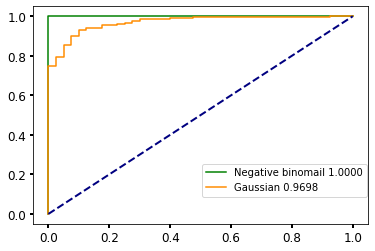

Number of differentially expressed genes:        Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
label                                                                
0.0                              40                             40   
1.0                            1747                           1747   

       log_likelihood_ratio  time  failure counter  
label                                               
0.0                      40    40               40  
1.0                    1747  1747             1747  
AUC for GPcounts with Negative Binomial likelihood 1.0
AUC for GPcounts with Gaussian likelihood 0.9697910704064109
GPcounts with Negative Binomial likelihood
AUC: 1.0
the numbers of genes less than 0.05 : 1691
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)
214


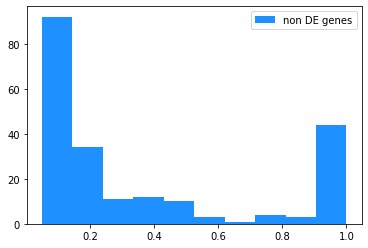

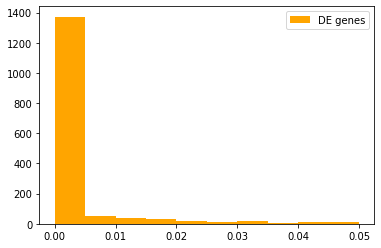

GPcounts with Gaussian likelihood
AUC: 0.9697910704064109
the numbers of genes greater than 0.05 : 1758
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


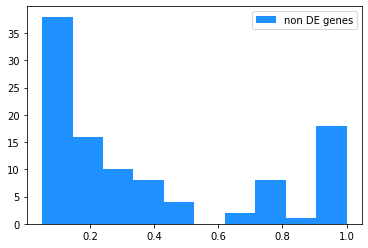

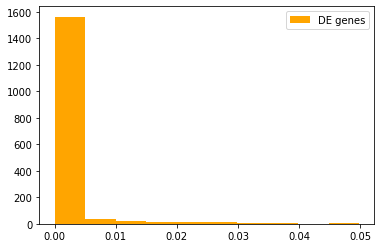

In [8]:
D = NegativeBinomial.shape[0]
print(D)

true_label = np.zeros(D)
for j in range(D):
    if NegativeBinomial['log_likelihood_ratio'][j] > 0:
        true_label[j] = 1

labels = pd.DataFrame(true_label, index =NegativeBinomial.index.values, columns =['label'])
NegativeBinomial = pd.concat([NegativeBinomial,labels],axis = 1)

fig = plt.figure()

plt.tick_params(labelsize='large', width=2)     
fpr_NB, tpr_NB, thresholds_NB = metrics.roc_curve( NegativeBinomial['label'], NegativeBinomial['log_likelihood_ratio'])
AUC_NB=metrics.auc(fpr_NB, tpr_NB)
plt.plot(fpr_NB, tpr_NB,color='green',label='Negative binomail {0:.4f}'.format(AUC_NB))


fpr_G, tpr_G, thresholds_G = metrics.roc_curve(NegativeBinomial['label'],Gaussian['log_likelihood_ratio'])
AUC_G=metrics.auc(fpr_G, tpr_G)
plt.plot(fpr_G, tpr_G, color='darkorange', label='Gaussian {0:.4f}'.format(AUC_G))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
'''
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1, 2, 2)

precision_NB, recall_NB, thresholds_NB = metrics.precision_recall_curve( NegativeBinomial['label'], NegativeBinomial['log_likelihood_ratio'])
plt.plot( recall_NB,precision_NB,color='green',label='GPcounts with Negative binomail likelihood')

precision_G, recall_G, thresholds_G = metrics.precision_recall_curve(NegativeBinomial['label'],Gaussian['log_likelihood_ratio'])
plt.plot(recall_G, precision_G, color='darkorange', label='GPcounts with Gaussian ll')

precision_P, recall_P, thresholds_P = metrics.precision_recall_curve( NegativeBinomial['label'], Poisson['log_likelihood_ratio'])
plt.plot( recall_P,precision_P,color='blue',label='GPcounts with Poisson ll')

plt.xlabel('recall')
plt.ylabel('precision')
'''
plt.legend(loc='upper center', bbox_to_anchor=(.75, 0.30))
plt.show()

print('Number of differentially expressed genes:',NegativeBinomial.groupby('label').count())
print('AUC for GPcounts with Negative Binomial likelihood',AUC_NB)
print('AUC for GPcounts with Gaussian likelihood',AUC_G)


pval_NB = 1 - stats.chi2.cdf(NegativeBinomial['log_likelihood_ratio'], df=1)
pval_NB.reshape(-1)[2]
pval_NB = pd.DataFrame(pval_NB)
DE_pval_NB = list(pval_NB.loc[(pval_NB[0] < 0.05)].index.values)
non_DE_pval_NB = list(pval_NB.loc[(pval_NB[0] >= 0.05)].index.values)

qvals_NB = []
#pval_NB=pval_NB['2']
qvals_NB = qvalue(pval_NB.values)
count_NB = 0

for i in (qvals_NB):
    if i < 0.05 :
        count_NB = count_NB + 1
    
print("GPcounts with Negative Binomial likelihood")        
print('AUC:',AUC_NB)       
print ("the numbers of genes less than 0.05 : " + str(count_NB))
print("kstest for non DE genes:",stats.kstest(pval_NB.iloc[non_DE_pval_NB,:].values, 'uniform', args=(0,1)))
plt.hist(pval_NB.iloc[non_DE_pval_NB,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
print(len(pval_NB.iloc[non_DE_pval_NB,:].values.ravel()))
plt.show()
plt.hist(pval_NB.iloc[DE_pval_NB,:].values.ravel(),color="orange", label="DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

pval_G = 1 - stats.chi2.cdf(Gaussian['log_likelihood_ratio'], df=1)
pval_G.reshape(-1)[2]
pval_G = pd.DataFrame(pval_G)
DE_pval_G = list(pval_G.loc[(pval_G[0] < 0.05)].index.values)
non_DE_pval_G = list(pval_G.loc[(pval_G[0] >= 0.05)].index.values)
qvals_G = []
#pval=pval['2']
qvals_G = qvalue(pval_G.values)
count_G = 0
for i in qvals_G :
    if i < 0.05 :
        count_G = count_G + 1

print("GPcounts with Gaussian likelihood")        
print('AUC:',AUC_G)       
print ("the numbers of genes greater than 0.05 : " + str(count_G))
print("kstest for non DE genes:",stats.kstest(pval_G.iloc[non_DE_pval_G,:].values, 'uniform', args=(0, 1)))
plt.hist(pval_G.iloc[non_DE_pval_G,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
plt.hist(pval_G.iloc[DE_pval_G,:].values.ravel(),color="orange", label="DE genes", bins=10)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()